# Natural Computing - Project
#### Submission by group 25 (Chihab Amghane, Max Driessen, Jordy Naus)

The code below uses the DEAP framework (https://github.com/deap/deap), which is a very intuitive framework for evolutionary algorithms and genetic programming.

## Imports

In [1]:
# DEAP
from deap import gp, base, tools, creator, algorithms

# Data processing and plotting
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Requirements for the algorithm
from operator import attrgetter
from functools import partial

# Standard python imports
import random, pickle, math, re, os
import numpy as np

# Magic for inline plots
%matplotlib inline

## Helper functions

In [2]:
def exp(x):
    return np.exp(np.clip(x, -float('inf'), 709.))

In [3]:
def get_avg_height(individual):
    return sum([tree.height for tree in individual])/N_CLASSES_TO_USE

In [4]:
def get_total_size(individual):
    return sum([len(tree) for tree in individual])

In [5]:
def print_trees(individual):
    for tree in individual:
        print(f"{tree}\n")

## Global parameters

In [6]:
# Dataset parameters
DATASET = "MNIST" # choose from {"MNIST", "Fashion-MNIST"} 
N_CLASSES_TO_USE = 4 # at most 10
USE_NORMALIZATION = True
USE_ANTI_ALIASING = False

# Individual tree parameters
MAX_ARITY = 10
MIN_INITIAL_DEPTH = 3
MAX_INITIAL_DEPTH = 5

MAX_DEPTH_CAPPED = True
MAX_AVG_DEPTH = 20

# Fitness parameters
N_SAMPLES_TO_TEST = 50

# Evolution parameters
N_GENERATIONS = 1000
POPULATION_SIZE = 100

TOURNAMENT_SIZE = 2
SIZE_TOURNAMENT = True
P_SMALLER_WINS = 0.65

P_CROSSOVER = 1.0
P_CROSSOVER_PER_TREE = 1.0

P_MUTATION = 0.3
P_MUTATION_PER_TREE = 0.2
MIN_MUTATION_DEPTH = 1
MAX_MUTATION_DEPTH = 3

# Filename parameters
RESULTS_FILENAME = "results.pkl"

## Loading preprocessed data

In [7]:
# Set the correct data filename
filename = f"{DATASET}-{N_CLASSES_TO_USE}{'-Norm' if USE_NORMALIZATION else ''}{'-AA' if USE_ANTI_ALIASING else ''}.pkl"

# If the data has not yet been preprocessed in the specified way, do so now
if not os.path.exists(os.path.join("data", filename)):
    print("Preprocessed dataset does not exist yet, creating now.")
    os.system(f"python Preprocessing.py -d {DATASET} -c {N_CLASSES_TO_USE}" + \
              f"{' --aa' if USE_ANTI_ALIASING else ''}{' --n' if USE_NORMALIZATION else ''}")

# Load the preprocessed data
with open(os.path.join("data", filename), "rb") as f:
    (X_train, Y_train), (X_test, Y_test) = pickle.load(f)

## Defining operators

In [8]:
# Create set of functions and terminals, with one terminal for each pixel
pset = gp.PrimitiveSet("main", X_train.shape[1])

In [9]:
# Define operators (with a variable number of inputs)
def linear(*args):
    return sum(args)

def inverse(*args):
    return -sum(args)

def tanh(*args):
    return math.tanh(sum(args))

def sigmoid(*args):
    return 1.0/(1.0 + exp(-sum(args)))

def step(*args):
    return float(sum(args) >= 0)

def sine(*args):
    return math.sin(sum(args))

def cosine(*args):
    return math.cos(sum(args))

def gaussian(*args):
    return 0.5*sum(args)*(1.0+math.tanh(math.sqrt(2.0/math.pi)*(sum(args) + 0.044715*sum(args)**3)))
                          
def absolute(*args):
    return abs(sum(args))

In [10]:
# Add operators to the set (using a "hacky" solution to allow variable arities)
for arity in range(1, MAX_ARITY+1):
    pset.addPrimitive(linear, arity)
    pset.addPrimitive(inverse, arity)
    pset.addPrimitive(tanh, arity)
    pset.addPrimitive(sigmoid, arity)
    pset.addPrimitive(step, arity)
    pset.addPrimitive(sine, arity)
    pset.addPrimitive(cosine, arity)
    pset.addPrimitive(gaussian, arity)
    pset.addPrimitive(absolute, arity)

## Defining individuals

In [11]:
# Intialize the toolbox which will contain all sorts of functions for the genetic programming process
toolbox = base.Toolbox()

In [12]:
# Define how to create a random expression/tree (using half-and-half intialization)
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=MIN_INITIAL_DEPTH, max_=MAX_INITIAL_DEPTH)

In [13]:
# Define classes for fitness, trees and individuals (using DEAP's creator module)
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Tree", gp.PrimitiveTree)
creator.create("Individual", list, fitness=creator.FitnessMin)

In [14]:
# Define how to initialize a tree, individual or population
toolbox.register("tree", tools.initIterate, creator.Tree, toolbox.expr)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.tree, N_CLASSES_TO_USE)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

## Fitness function

In [15]:
# Define how to compile a single tree and an individual
toolbox.register("compile_tree", gp.compile, pset=pset)
toolbox.register("compile_individual", lambda individual: [toolbox.compile_tree(t) for t in individual])

In [16]:
# Define fitness function   
def fitness(individual, n_samples_to_test):
    # Compile the functions corresponding to the individual
    funcs = toolbox.compile_individual(individual)
    
    # Define how to compute softmax and cross-entropy
    def _softmax(x):
        return exp(x)/np.sum(exp(x), axis=0)
    def _cross_entropy(pred, label):
        return -np.log(exp(pred[label])/np.sum(exp(pred), axis=0))
    
    # Create a list of samples to test, ensuring an equal number of samples from each class
    sample_indices = []
    n_samples_per_class = int(n_samples_to_test/N_CLASSES_TO_USE)
    for c in range(N_CLASSES_TO_USE):
        c_indices = np.where(Y_train == c)[0]
        assert len(c_indices) >= n_samples_per_class, \
            f"Class {c} has too few elements to reach the desired number of evaluation samples"
        sample_indices.extend(np.random.permutation(c_indices)[:n_samples_per_class])
    
    # Compute cross-entropy loss for each of the samples
    losses = []
    for i in sample_indices:
        X_sample, Y_sample = X_train[i], Y_train[i]
        output = _softmax([f(*X_sample) for f in funcs])
        losses.append(_cross_entropy(output, Y_sample))
    
    # Return the average cross-entropy loss
    return (np.average(losses),)

In [17]:
# Add the fitness function to the toolbox
toolbox.register("evaluate", fitness, n_samples_to_test=N_SAMPLES_TO_TEST)

## Evolution components

##### Parent selection

In [18]:
# Redefine the tools.selDoubleTournament function for our multi-tree individuals (all comments from the original function have been removed to aid readability; the function remains unchanged 
# except for the usage of get_total_size instead of len (as well as some differences in imports and python version)
def selDoubleTournament(individuals, k, fitness_size, parsimony_size, fitness_first, fit_attr="fitness"):
    assert (1 <= parsimony_size <= 2), "Parsimony tournament size has to be in the range [1, 2]."

    def _sizeTournament(individuals, k, select):
        chosen = []
        for i in range(k):
            prob = parsimony_size / 2.
            ind1, ind2 = select(individuals, k=2)

            # This is the part that matters for our re-implementation: we use the total size of
            # all trees instead of the length of the individual, which is equal for all individuals
            if get_total_size(ind1) > get_total_size(ind2):
                ind1, ind2 = ind2, ind1
            elif get_total_size(ind1) == get_total_size(ind2):
                prob = 0.5

            chosen.append(ind1 if random.random() < prob else ind2)

        return chosen

    def _fitTournament(individuals, k, select):
        chosen = []
        for i in range(k):
            aspirants = select(individuals, k=fitness_size)
            chosen.append(max(aspirants, key=attrgetter(fit_attr)))
        return chosen

    if fitness_first:
        tfit = partial(_fitTournament, select=tools.selRandom)
        return _sizeTournament(individuals, k, tfit)
    else:
        tsize = partial(_sizeTournament, select=tools.selRandom)
        return _fitTournament(individuals, k, tsize)

In [19]:
# Define how to select parents (either a double tournament that controls for bloat or a single tournament that does not)
if SIZE_TOURNAMENT:
    toolbox.register("select", selDoubleTournament, fitness_size=TOURNAMENT_SIZE, 
                     parsimony_size=P_SMALLER_WINS*2, fitness_first=False)
else:
    toolbox.register("select", tools.selTournament, tournsize=TOURNAMENT_SIZE)

##### Crossover

In [20]:
# Define how to perform crossover
def crossover(ind1, ind2):
    new_ind1, new_ind2 = [], []
    for i in range(N_CLASSES_TO_USE):
        tree1, tree2 = ind1[i], ind2[i]
        if np.random.random() < P_CROSSOVER_PER_TREE:
            tree1, tree2 = gp.cxOnePoint(tree1, tree2)
        new_ind1.append(tree1)
        new_ind2.append(tree2)
    return (creator.Individual(new_ind1), creator.Individual(new_ind2))

In [21]:
# Add the crossover ("mate") function to the toolbox
toolbox.register("mate", crossover)

##### Mutation

In [22]:
# Define how to create a "mutation tree"
toolbox.register("expr_mut", gp.genHalfAndHalf, min_=MIN_MUTATION_DEPTH, max_=MAX_MUTATION_DEPTH)

In [23]:
# Define how to perform mutation
def mutate(individual):
    new_ind = []
    for tree in individual:
        if np.random.random() < P_MUTATION_PER_TREE:
            new_ind.append(gp.mutUniform(tree, expr=toolbox.expr_mut, pset=pset)[0])
        else:
            new_ind.append(tree)
    return creator.Individual(new_ind),

In [24]:
# Add the mutation ("mutate") function to the toolbox
toolbox.register("mutate", mutate)

##### Height boundary

In [25]:
# Define upper limits for height of trees (if limit is exceeded, a random parent is used instead)
if MAX_DEPTH_CAPPED:
    toolbox.decorate("mate", gp.staticLimit(key=get_avg_height, max_value=MAX_AVG_DEPTH))
    toolbox.decorate("mutate", gp.staticLimit(key=get_avg_height, max_value=MAX_AVG_DEPTH))

## Defining statistics

In [26]:
# Describe which kinds of statistics to keep track of
stats_fit = tools.Statistics(key = lambda ind: ind.fitness.values)
stats_height = tools.Statistics(key = get_avg_height)
mstats = tools.MultiStatistics(fitness=stats_fit, height=stats_height)

In [27]:
# Describe metrics to keep track of for each statistic
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

## Running the genetic programming algorithm

In [28]:
pop = toolbox.population(POPULATION_SIZE)
hof = tools.HallOfFame(1)
pop, log = algorithms.eaSimple(population=pop, toolbox=toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION, 
                                     ngen=N_GENERATIONS, stats=mstats, halloffame=hof, verbose=True)

   	      	                     fitness                     	                     height                     
   	      	-------------------------------------------------	------------------------------------------------
gen	nevals	avg   	gen	max    	min    	nevals	std      	avg  	gen	max 	min 	nevals	std     
0  	100   	1.4531	0  	1.58969	1.28004	100   	0.0545996	4.015	0  	4.75	3.25	100   	0.382132
1  	100   	1.4334	1  	1.55522	1.33874	100   	0.0483309	4.1675	1  	5.5 	3.25	100   	0.477042
2  	100   	1.41706	2  	1.5133 	1.33196	100   	0.041209 	4.32  	2  	5.75	3.25	100   	0.492544
3  	100   	1.39636	3  	1.50533	1.30172	100   	0.0353964	4.425 	3  	6   	3.25	100   	0.645659
4  	100   	1.38379	4  	1.47917	1.28916	100   	0.0317089	4.5   	4  	6.5 	3.25	100   	0.642262
5  	100   	1.38242	5  	1.43376	1.30077	100   	0.0251079	4.57  	5  	6.5 	3.5 	100   	0.57563 
6  	100   	1.37667	6  	1.48011	1.30934	100   	0.0259692	4.6075	6  	7   	3   	100   	0.60751 
7  	100   	1.37706	7  	1.44711	1.30572	10

85 	100   	1.25541	85 	1.35427	1.13864	100   	0.0379607	5.07  	85 	7.25	4   	100   	0.566877
86 	100   	1.24166	86 	1.32486	1.14294	100   	0.042006 	5.12  	86 	6   	3.5 	100   	0.567318
87 	100   	1.23541	87 	1.34509	1.13578	100   	0.0386283	5.11  	87 	6.75	3.5 	100   	0.604483
88 	100   	1.23593	88 	1.33942	1.13652	100   	0.0331164	5.1125	88 	6.75	4   	100   	0.583497
89 	100   	1.23499	89 	1.33227	1.06994	100   	0.0415651	5.115 	89 	6.75	3.5 	100   	0.617879
90 	100   	1.23093	90 	1.31836	1.15195	100   	0.0360151	5.1875	90 	6.75	3.75	100   	0.649399
91 	100   	1.23315	91 	1.37209	1.07523	100   	0.0512863	5.1625	91 	7.25	4   	100   	0.659901
92 	100   	1.22045	92 	1.40818	1.10947	100   	0.0453961	5.1675	92 	7.25	4   	100   	0.697366
93 	100   	1.22178	93 	1.34105	1.084  	100   	0.0472479	5.22  	93 	6.5 	3.75	100   	0.697567
94 	100   	1.20494	94 	1.32575	1.06676	100   	0.054023 	5.135 	94 	6.5 	3.75	100   	0.622917
95 	100   	1.19479	95 	1.37354	1.05542	100   	0.0555077	5.2175	95 	6.7

173	100   	1.10959	173	1.20564	0.998282	100   	0.0476162	4.285 	173	5.75	3   	100   	0.666164
174	100   	1.1177 	174	1.32255	1.03299 	100   	0.0522954	4.275 	174	5.75	3   	100   	0.692369
175	100   	1.11056	175	1.27158	0.995885	100   	0.0493253	4.3675	175	6.25	3   	100   	0.733532
176	100   	1.11319	176	1.26868	1.01984 	100   	0.0442265	4.4075	176	6.5 	2   	100   	0.779146
177	100   	1.11875	177	1.22905	1.01309 	100   	0.0416219	4.29  	177	6.5 	3.25	100   	0.621208
178	100   	1.10963	178	1.28309	1.02497 	100   	0.0437484	4.25  	178	6   	3.25	100   	0.575543
179	100   	1.10671	179	1.23333	1.01036 	100   	0.0469891	4.2475	179	6.25	2.75	100   	0.58148 
180	100   	1.099  	180	1.23992	0.98844 	100   	0.0472802	4.2075	180	6.5 	3   	100   	0.635467
181	100   	1.10378	181	1.22511	0.999696	100   	0.0462874	4.275 	181	5.5 	3.25	100   	0.547152
182	100   	1.09766	182	1.20669	0.957922	100   	0.0506678	4.38  	182	6   	3.5 	100   	0.591058
183	100   	1.09824	183	1.2005 	0.953287	100   	0.0446222	4.3

261	100   	1.06755	261	1.15772	0.966091	100   	0.0383985	3.415 	261	5.5 	2   	100   	0.847216
262	100   	1.07019	262	1.2457 	0.973409	100   	0.0436253	3.4825	262	5.25	2   	100   	0.790771
263	100   	1.06074	263	1.1627 	0.954311	100   	0.0443054	3.6825	263	5.25	2   	100   	0.74821 
264	100   	1.06279	264	1.26862	0.968827	100   	0.0487289	3.6475	264	5.25	2   	100   	0.746739
265	100   	1.06832	265	1.18345	0.971102	100   	0.045607 	3.8   	265	5.75	1.25	100   	0.781825
266	100   	1.07377	266	1.23577	0.975456	100   	0.0535685	3.8575	266	5.5 	2   	100   	0.705563
267	100   	1.06797	267	1.28875	0.968666	100   	0.0486601	3.7   	267	5.25	2   	100   	0.755811
268	100   	1.06635	268	1.18568	0.963893	100   	0.043304 	3.5375	268	5.75	1.5 	100   	0.84954 
269	100   	1.0667 	269	1.15594	0.985831	100   	0.0346971	3.3875	269	6.25	1.5 	100   	0.954185
270	100   	1.06838	270	1.20397	0.952341	100   	0.0487525	3.3875	270	6.25	1.5 	100   	0.969778
271	100   	1.0708 	271	1.29967	0.960812	100   	0.0519206	3.2

349	100   	1.08828	349	1.24584	0.959106	100   	0.0538492	3.0225	349	5.25	1.75	100   	0.761655
350	100   	1.07423	350	1.21196	0.957842	100   	0.0569001	2.9225	350	4.75	1.5 	100   	0.809085
351	100   	1.07654	351	1.25918	0.928327	100   	0.0528699	2.8625	351	5   	1.5 	100   	0.782125
352	100   	1.08743	352	1.24049	0.987077	100   	0.0515232	2.94  	352	5   	1.75	100   	0.752596
353	100   	1.08084	353	1.33389	0.919629	100   	0.0578878	3.0425	353	5.5 	1.75	100   	0.803162
354	100   	1.08514	354	1.24693	0.972173	100   	0.0526473	3.1025	354	5.5 	1.5 	100   	0.810166
355	100   	1.08338	355	1.26556	0.966061	100   	0.0634005	2.93  	355	4.75	1.75	100   	0.763282
356	100   	1.07719	356	1.21843	0.959   	100   	0.0537614	2.83  	356	5.25	1.75	100   	0.702567
357	100   	1.08325	357	1.22152	0.99774 	100   	0.05223  	2.84  	357	4.25	1.5 	100   	0.690579
358	100   	1.0715 	358	1.27748	0.973243	100   	0.0533145	2.9075	358	4.25	1.5 	100   	0.692509
359	100   	1.08052	359	1.23386	0.9982  	100   	0.0495736	2.9

437	100   	1.04703	437	1.27452	0.88551 	100   	0.0691577	2.98  	437	5   	1.25	100   	0.702389
438	100   	1.04784	438	1.40907	0.915009	100   	0.0731853	3.02  	438	5   	1.75	100   	0.67424 
439	100   	1.05332	439	1.31583	0.92359 	100   	0.073854 	2.9475	439	4.5 	1.25	100   	0.666422
440	100   	1.03648	440	1.22783	0.860322	100   	0.0679365	2.945 	440	4.5 	1.25	100   	0.707619
441	100   	1.02358	441	1.21885	0.87302 	100   	0.0618251	2.9375	441	4.75	1.25	100   	0.737712
442	100   	1.03072	442	1.24686	0.83132 	100   	0.067872 	3.0675	442	4.75	1.5 	100   	0.685433
443	100   	1.02557	443	1.22093	0.910927	100   	0.055274 	3.075 	443	5.25	1.5 	100   	0.798044
444	100   	1.01559	444	1.14745	0.908122	100   	0.0521467	3.07  	444	5   	1.5 	100   	0.821645
445	100   	1.03721	445	1.25699	0.903805	100   	0.0672375	3.2   	445	6.25	1.5 	100   	0.928036
446	100   	1.03885	446	1.29042	0.870409	100   	0.0721838	3.3375	446	6.5 	1.75	100   	0.988291
447	100   	1.03874	447	1.26212	0.840838	100   	0.0698112	3.4

524	100   	1.01325 	524	1.21799	0.895702	100   	0.0711183	3.6375	524	6   	2   	100   	0.787698
525	100   	1.00753 	525	1.26525	0.866129	100   	0.0697659	3.5375	525	5.5 	1.75	100   	0.788491
526	100   	1.00383 	526	1.28285	0.862687	100   	0.0673202	3.5575	526	5.25	2   	100   	0.849158
527	100   	1.00171 	527	1.17601	0.868547	100   	0.060675 	3.52  	527	5.5 	2   	100   	0.82665 
528	100   	1.00132 	528	1.22339	0.864023	100   	0.0628029	3.49  	528	6   	2   	100   	0.879574
529	100   	1.00529 	529	1.19987	0.857511	100   	0.069628 	3.4475	529	7   	1.75	100   	1.02974 
530	100   	1.00353 	530	1.14762	0.821484	100   	0.0670256	3.51  	530	6.75	2   	100   	0.998073
531	100   	1.01057 	531	1.19182	0.831947	100   	0.0667071	3.475 	531	7.25	1.75	100   	1.08253 
532	100   	1.00281 	532	1.24493	0.880563	100   	0.0639968	3.4075	532	6.25	1.75	100   	0.971246
533	100   	1.00145 	533	1.13586	0.859487	100   	0.0582782	3.1725	533	5.5 	1.75	100   	0.663038
534	100   	1.00207 	534	1.19219	0.844719	100   	0.

611	100   	0.98986 	611	1.29571	0.880723	100   	0.0619577	3.7475	611	5.5 	2.25	100   	0.718066
612	100   	0.977009	612	1.17049	0.872402	100   	0.055773 	3.6075	612	5   	2   	100   	0.651206
613	100   	0.985991	613	1.3418 	0.837896	100   	0.0723423	3.5875	613	5.25	2.25	100   	0.717962
614	100   	0.997686	614	1.25699	0.864677	100   	0.0683344	3.5125	614	5.25	2.25	100   	0.659901
615	100   	0.992524	615	1.36933	0.855169	100   	0.0746944	3.4225	615	5   	2.25	100   	0.566453
616	100   	0.999576	616	1.22299	0.863619	100   	0.0669793	3.4425	616	5   	1.75	100   	0.544122
617	100   	0.991476	617	1.17098	0.865997	100   	0.0605818	3.475 	617	5   	1.75	100   	0.59739 
618	100   	0.990764	618	1.13231	0.877763	100   	0.0541998	3.5275	618	5.25	1.75	100   	0.645073
619	100   	0.991669	619	1.27105	0.879344	100   	0.0614632	3.505 	619	5   	1.75	100   	0.661419
620	100   	0.995123	620	1.24934	0.821445	100   	0.075851 	3.625 	620	5.5 	2   	100   	0.720677
621	100   	0.99035 	621	1.22182	0.852536	100   	0.

698	100   	0.975256	698	1.27725	0.823618	100   	0.0644982	4.4625	698	6.5 	2.5 	100   	0.794021
699	100   	0.980508	699	1.12793	0.857667	100   	0.0582102	4.4625	699	6.25	2.5 	100   	0.841409
700	100   	0.978793	700	1.19118	0.831423	100   	0.0691939	4.4925	700	6.5 	2.75	100   	0.863463
701	100   	0.978586	701	1.19411	0.85411 	100   	0.0652885	4.66  	701	7.5 	2   	100   	0.851851
702	100   	0.967684	702	1.12099	0.835319	100   	0.0610836	4.69  	702	6.25	2.75	100   	0.77146 
703	100   	0.9682  	703	1.14391	0.838326	100   	0.0627957	4.62  	703	7   	2.75	100   	0.87284 
704	100   	0.966972	704	1.15495	0.831387	100   	0.0528881	4.54  	704	6.75	2.75	100   	0.761347
705	100   	0.95821 	705	1.16184	0.855624	100   	0.0554709	4.58  	705	6.5 	3   	100   	0.700785
706	100   	0.971463	706	1.16878	0.854158	100   	0.0557548	4.57  	706	6.5 	3   	100   	0.76818 
707	100   	0.973044	707	1.18888	0.833413	100   	0.06079  	4.3225	707	6.5 	2.75	100   	0.828625
708	100   	0.967085	708	1.15079	0.878481	100   	0.

785	100   	0.957692	785	1.09838	0.814882	100   	0.0534985	4.5725	785	8.5 	2.75	100   	1.58323 
786	100   	0.947264	786	1.10124	0.804863	100   	0.055234 	4.485 	786	8.5 	2.75	100   	1.4781  
787	100   	0.938849	787	1.06501	0.817316	100   	0.0504064	4.29  	787	7.5 	2.75	100   	1.18465 
788	100   	0.95218 	788	1.1191 	0.82813 	100   	0.0595944	3.9675	788	8.5 	2.75	100   	0.908058
789	100   	0.943997	789	1.16513	0.836617	100   	0.061866 	4.0275	789	6.25	2.5 	100   	0.762311
790	100   	0.954308	790	1.08535	0.829828	100   	0.058096 	4.145 	790	6.25	2.75	100   	0.793867
791	100   	0.949492	791	1.19749	0.829498	100   	0.063471 	4.09  	791	6.25	2.75	100   	0.780641
792	100   	0.944704	792	1.1636 	0.781926	100   	0.0620954	4.0975	792	6.25	2.75	100   	0.758201
793	100   	0.950881	793	1.28512	0.820144	100   	0.0685647	4.3025	793	6.25	3   	100   	0.710893
794	100   	0.940799	794	1.12888	0.826561	100   	0.060869 	4.51  	794	6.5 	2.75	100   	0.788923
795	100   	0.946179	795	1.08175	0.859138	100   	0.

872	100   	0.999167	872	1.21218	0.868538	100   	0.0638222	4.0375	872	6   	2   	100   	0.814996
873	100   	0.998275	873	1.15704	0.823853	100   	0.06172  	4.03  	873	6.25	2.5 	100   	0.744379
874	100   	0.98198 	874	1.12574	0.854527	100   	0.0619365	4.02  	874	6   	2.5 	100   	0.743875
875	100   	0.983942	875	1.13306	0.790587	100   	0.0669863	3.8325	875	6   	2.5 	100   	0.781869
876	100   	0.989469	876	1.09841	0.873395	100   	0.0531222	3.755 	876	5.75	2.25	100   	0.781809
877	100   	0.982852	877	1.328  	0.849032	100   	0.0684849	3.6   	877	5.75	2   	100   	0.682825
878	100   	0.994301	878	1.14715	0.844959	100   	0.0652427	3.6525	878	5.75	2.25	100   	0.6882  
879	100   	0.991523	879	1.19052	0.860661	100   	0.0584113	3.5775	879	5.5 	2.25	100   	0.702402
880	100   	0.997646	880	1.15515	0.85521 	100   	0.0679426	3.48  	880	5.75	2   	100   	0.808301
881	100   	0.986328	881	1.14005	0.868904	100   	0.0546473	3.26  	881	5.75	2   	100   	0.823043
882	100   	0.997229	882	1.22264	0.863261	100   	0.

959	100   	0.999242	959	1.30829	0.848802	100   	0.0676866	2.7225	959	4.25	1.75	100   	0.641185
960	100   	1.00374 	960	1.25765	0.854394	100   	0.0667624	2.705 	960	4.25	1.75	100   	0.605578
961	100   	1.01299 	961	1.25294	0.862196	100   	0.0652459	2.575 	961	4.5 	1.5 	100   	0.588961
962	100   	1.01386 	962	1.25805	0.877474	100   	0.0755395	2.725 	962	5   	1.5 	100   	0.684197
963	100   	0.999235	963	1.11695	0.868865	100   	0.0619216	2.595 	963	4.75	1.5 	100   	0.704255
964	100   	0.998587	964	1.12601	0.873707	100   	0.0583476	2.6575	964	7   	1.5 	100   	0.781549
965	100   	1.00346 	965	1.18112	0.883618	100   	0.058179 	2.665 	965	7.5 	1.5 	100   	0.863293
966	100   	0.997969	966	1.17091	0.891461	100   	0.0550831	2.77  	966	7.5 	1.5 	100   	1.06986 
967	100   	0.993093	967	1.34694	0.85573 	100   	0.0697101	2.7975	967	8.25	1.5 	100   	1.16495 
968	100   	0.995139	968	1.30812	0.86303 	100   	0.0765774	2.7375	968	7   	1.5 	100   	0.928288
969	100   	0.98425 	969	1.21893	0.863107	100   	0.

In [29]:
# Store results
with open(RESULTS_FILENAME, "wb") as f:
    pickle.dump((pop, log, hof), f)

## Plotting statistics

In [30]:
# Extract generation IDs, minimum fitnesses and average total heights per generation
gen = log.select("gen")
fitness_best = log.chapters["fitness"].select("min") 
height_avg = log.chapters["height"].select("avg")

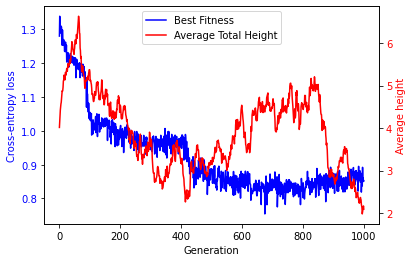

In [31]:
# Plot line for minimum fitness
fig, fit_ax = plt.subplots()
fit_line = fit_ax.plot(gen, fitness_best, "b-", label="Best Fitness")
fit_ax.set_xlabel("Generation")
fit_ax.set_ylabel(f"Cross-entropy loss", color="b")
for tl in fit_ax.get_yticklabels():
    tl.set_color("b")

# Plot line for average total height
height_ax = fit_ax.twinx()
height_line = height_ax.plot(gen, height_avg, "r-", label="Average Total Height")
height_ax.set_ylabel("Average height", color="r")
for tl in height_ax.get_yticklabels():
    tl.set_color("r")

# Add legend
lines = fit_line + height_line
labs = [l.get_label() for l in lines]
fit_ax.legend(lines, labs, loc="upper center")

# Show the result
plt.show()

## Inspecting the best individual

In [32]:
best_ind = hof[0]
print(f"Fitness of best individual: {best_ind.fitness}")

Fitness of best individual: (0.7544194200319794,)


##### Printing trees

In [33]:
# Print the trees of the best individual
print_trees(best_ind)

linear(ARG102, ARG108, linear(ARG116, linear(linear(tanh(ARG52, ARG48, ARG102, ARG215, linear(ARG176, ARG108, ARG108, ARG102, ARG108, ARG108), ARG125), ARG222, sigmoid(linear(ARG102, ARG108, ARG54, ARG102, ARG149, ARG10), step(ARG102, ARG169, ARG208, ARG206, ARG42, ARG187, ARG235, ARG2, linear(ARG108, linear(ARG108, linear(linear(ARG208, linear(ARG116, ARG149, inverse(ARG102), ARG207, ARG208, ARG102), ARG108, ARG116, ARG235, ARG108), ARG208, linear(linear(ARG208, ARG108, ARG108, cosine(ARG247, ARG133, ARG112, ARG179, inverse(ARG89, ARG206, cosine(linear(linear(ARG208, ARG108, ARG108, ARG208, ARG208, ARG108), ARG38, ARG208, ARG108, ARG62, ARG86), ARG143, ARG159, ARG224, ARG98, ARG120, ARG208), step(inverse(ARG164, ARG233)))), inverse(ARG108), ARG108), ARG38, ARG207, ARG108, ARG166, ARG86), ARG102, ARG38, ARG235)), ARG208, ARG108, ARG149, ARG86), ARG108), gaussian(ARG149)), ARG130), ARG149, inverse(ARG108), ARG116, ARG214, ARG108), ARG108, ARG149, ARG48, ARG108), ARG48, ARG116, linear(AR

##### Computing training & validation accuracy

In [34]:
# Retrieving predictions from an individual
def get_predictions(individual, X):
    funcs = toolbox.compile_individual(individual)
    predictions = []
    for i in range(X.shape[0]):
        outputs_i = [f(*X[i]) for f in funcs]
        predictions.append(np.argmax(outputs_i))
    return predictions

In [35]:
# Retrieve predictions of the best individual on the training and validation sets
Y_train_pred = get_predictions(best_ind, X_train)
Y_test_pred = get_predictions(best_ind, X_test)

In [36]:
# Compute accuracy of predictions
def compute_accuracy(Y_pred, Y_true):
    n_correct = np.sum(Y_pred == Y_true)
    return n_correct/Y_true.shape[0]

In [37]:
# Print training and validation accuracies of the best individual
print(f"Training accuracy: {compute_accuracy(Y_train_pred, Y_train)}")
print(f"Validation accuracy: {compute_accuracy(Y_test_pred, Y_test)}")

Training accuracy: 0.8310172093399046
Validation accuracy: 0.8287226365167187


##### Confusion matrices

In [38]:
# Compute confusion matrices
cm_train = confusion_matrix(Y_train, Y_train_pred, labels=range(N_CLASSES_TO_USE))
cm_test = confusion_matrix(Y_test, Y_test_pred, labels=range(N_CLASSES_TO_USE))

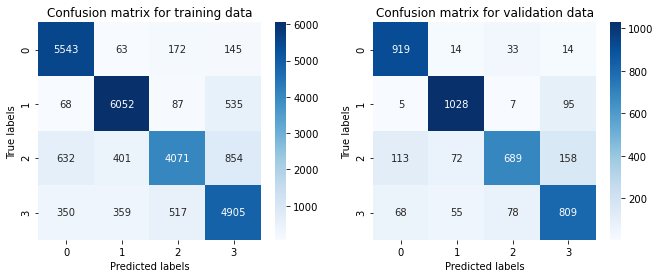

In [39]:
# Create figure
fig, ax = plt.subplots(1,2, figsize=(11,4))

# Plot confusion matrix for training data
sns.heatmap(cm_train, annot=True, fmt='g', ax=ax[0], cmap="Blues")
ax[0].set_xlabel('Predicted labels')
ax[0].set_ylabel('True labels')
ax[0].set_title('Confusion matrix for training data')

# Plot confusion matrix for validation data
sns.heatmap(cm_test, annot=True, fmt='g', ax=ax[1], cmap="Blues")
ax[1].set_xlabel('Predicted labels')
ax[1].set_ylabel('True labels')
ax[1].set_title('Confusion matrix for validation data')

# Show the result
plt.show()

##### Used features

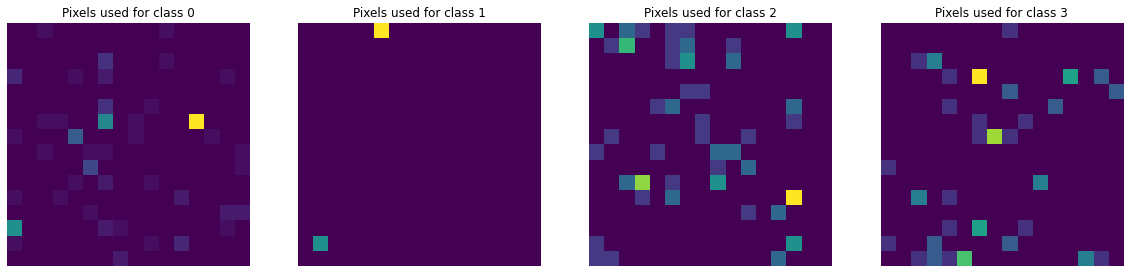

In [40]:
# Create plots of the inputs (pixels) used in the tree of the best individual for each class 
fig, ax = plt.subplots(1, N_CLASSES_TO_USE, figsize=(20,20/N_CLASSES_TO_USE))
for i, tree in enumerate(best_ind):
    inputs_used = list(map(int, re.findall("[0-9]+", str(tree))))
    input_tallies = np.zeros(X_train.shape[1])
    for arg in inputs_used:
        input_tallies[arg] += 1
    img_shape = int(math.sqrt(X_train.shape[1]))
    ax[i].imshow(input_tallies.reshape(img_shape, img_shape))
    ax[i].axis("off")
    ax[i].set_title(f"Pixels used for class {i}") 
plt.show()